# Analysing Router Logs

We will first import necessary libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# changing style
plt.style.use('ggplot')

## Strategy

1. We will try and simluate a few attacks on a router, and check whether those attacks can be detected in hindsight.
2. To do that we will start with generating some demo data for a router, inspired by my home router. This will be a monitor of active DHCP Clients. 
3. We will then try and analyse the data to find out anomalies in normal usage. 

# Generating _normal_ demo data

In [19]:
# columns
data = {
    'MAC' : [],
    'IP Address': [],
    'Device Name': [],
    'Interface': [],
    'Requested IP': [],
    'Time': []
}

In [20]:
# Creating a pandas dataframe

normal_log_db = pd.DataFrame(data)
normal_log_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time


In [26]:
# Writing functions for columns that we wanna generate randomly
def generate_mac_address():
    mac = [random.randint(0x00, 0xff) for i in range(6)]
    return ':'.join(map(lambda x: "%02x" % x, mac))

def generate_dest_ip_address():
    ip = [random.randint(0, 255) for i in range(4)]
    return '.'.join(map(str, ip))

def generate_device_ip_address():
    ip = '192.168.1.' + str(random.randint(0, 255))
    return ip

def generate_device_name():
    device_names = ['iPhone', 'Samsung', 'OnePlus', 'Nokia', 'Xiaomi', 'Oppo', 'Vivo', 'Realme', 'Micromax', 'Lenovo']
    return random.choice(device_names)

def generate_interface(): 
    interfaces = ['5gz', '2.4gz']
    return random.choice(interfaces)

def generate_date_time():
    # generate random date and time, but only in the range of a few days
    start_date = pd.to_datetime('2023-01-01')
    
    # generate random number of days
    days_to_add = random.randint(0, 10)
    
    # generate random number of seconds
    seconds_to_add = random.randint(0, 86400)
    
    # add random days and seconds to start date
    end_date = start_date + pd.Timedelta(days=days_to_add, seconds=seconds_to_add)
    
    # return timestamp as string
    return end_date.strftime('%Y-%m-%d %H:%M:%S')
    
    


In [27]:
# Generate normal data, consider a home environment. with 10 users. across a span of 10 days. Visiting 100 websites per device per day. 

normal_log_db = pd.DataFrame(columns=['MAC', 'IP Address', 'Device Name', 'Interface', 'Requested IP', 'Time'])

for i in range(10):
    temp_df = pd.DataFrame({
        'MAC' : [generate_mac_address() for j in range(100)],
        'IP Address': [generate_device_ip_address() for j in range(100)],
        'Device Name': [generate_device_name() for j in range(100)],
        'Interface': [generate_interface() for j in range(100)],
        'Requested IP': [generate_dest_ip_address() for j in range(100)],
        'Time': [generate_date_time() for j in range(100)]
    })
    
    normal_log_db = pd.concat([normal_log_db, temp_df], ignore_index=True)

normal_log_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time
0,06:12:9f:18:e4:ce,192.168.1.61,Micromax,2.4gz,149.22.54.76,2023-01-04 11:02:35
1,91:78:77:07:19:c0,192.168.1.36,Oppo,2.4gz,1.220.94.41,2023-01-08 13:34:53
2,0d:18:d9:73:0e:9d,192.168.1.164,Realme,2.4gz,142.22.107.199,2023-01-09 18:28:28
3,23:ac:32:79:71:2a,192.168.1.255,Realme,2.4gz,127.183.15.140,2023-01-07 01:47:24
4,f3:c0:01:bb:1a:9a,192.168.1.34,Lenovo,5gz,65.60.120.186,2023-01-11 00:22:43
...,...,...,...,...,...,...
995,84:7a:56:e2:86:2d,192.168.1.182,Realme,2.4gz,123.108.126.109,2023-01-01 04:35:45
996,4e:1b:68:56:b4:a2,192.168.1.253,Realme,2.4gz,166.118.55.191,2023-01-10 16:27:17
997,5e:f0:b4:f3:a1:32,192.168.1.15,Oppo,2.4gz,104.47.239.53,2023-01-01 18:36:23
998,86:d9:39:bb:77:b7,192.168.1.50,Micromax,5gz,13.231.61.68,2023-01-06 01:00:16


In [28]:
# now sort data by time
normal_log_db = normal_log_db.sort_values(by=['Time'])
normal_log_db

,MAC,IP Address,Device Name,Interface,Requested IP,Time
773,e1:73:57:02:b0:1b,192.168.1.27,Vivo,2.4gz,78.154.151.225,2023-01-01 00:19:34
454,30:61:84:59:f7:76,192.168.1.193,Oppo,5gz,225.215.60.165,2023-01-01 00:22:27
190,1e:0b:8e:81:6f:82,192.168.1.129,Nokia,5gz,56.202.109.233,2023-01-01 00:30:28
83,16:67:09:f4:f8:ab,192.168.1.63,Micromax,5gz,27.151.193.120,2023-01-01 00:45:34
334,49:c3:99:f0:95:c2,192.168.1.225,Nokia,5gz,93.141.84.156,2023-01-01 00:58:52
...,...,...,...,...,...,...
742,f0:11:69:50:1c:7e,192.168.1.147,Oppo,5gz,108.201.181.167,2023-01-11 22:46:39
968,28:2b:61:98:38:c5,192.168.1.69,iPhone,2.4gz,166.187.39.237,2023-01-11 22:48:59
907,01:ae:f2:56:88:52,192.168.1.246,Nokia,2.4gz,125.167.48.104,2023-01-11 23:11:48
555,81:7f:6d:36:f4:b9,192.168.1.162,Vivo,2.4gz,90.149.138.19,2023-01-11 23:12:55


Text(0.5, 1.0, 'Number of requests per day NORMAL')

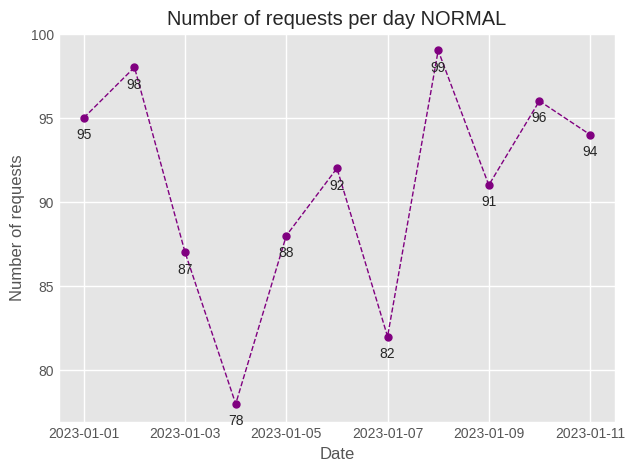

In [61]:
# let us plot the number of requests per day
normal_log_db['Time'] = pd.to_datetime(normal_log_db['Time'])
normal_log_db['Date'] = normal_log_db['Time'].dt.date 

# sort data by date
normal_log_db = normal_log_db.sort_values(by=['Date'])

normal_log_db.head()

# now let us plot the number of requests per day
dates = normal_log_db['Date'].value_counts()

# sorting dates
dates = dates.sort_index()

# plotting
# plt.figure(figsize=(20, 10))
plt.plot(dates.index, dates.values, color='purple', marker='o', linestyle='dashed', linewidth=1, markersize=5)

# also put labels on the markers a little over the markers for visibility
for i in range(len(dates)):
    plt.text(dates.index[i], dates.values[i]-1, dates.values[i], ha='center', va='center')
    
plt.xlabel('Date')
plt.ylabel('Number of requests')
plt.title('Number of requests per day NORMAL')


Text(0.5, 1.0, 'Number of requests per device NORMAL')

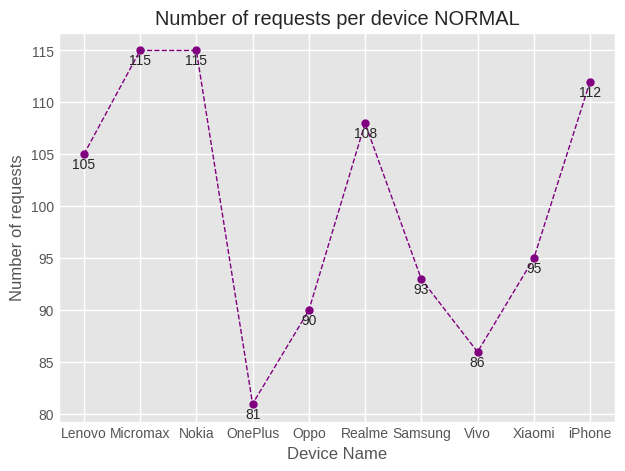

In [62]:
# let us now plot the number of requests per device

devices = normal_log_db['Device Name'].value_counts()

# sorting devices

devices = devices.sort_index()

# plotting
# plt.figure(figsize=(20, 10))
plt.plot(devices.index, devices.values, color='purple', marker='o', linestyle='dashed', linewidth=1, markersize=5)

# also put labels on the markers a little over the markers for visibility
for i in range(len(devices)):
    plt.text(devices.index[i], devices.values[i]-1, devices.values[i], ha='center', va='center')

plt.xlabel('Device Name')
plt.ylabel('Number of requests')
plt.title('Number of requests per device NORMAL')

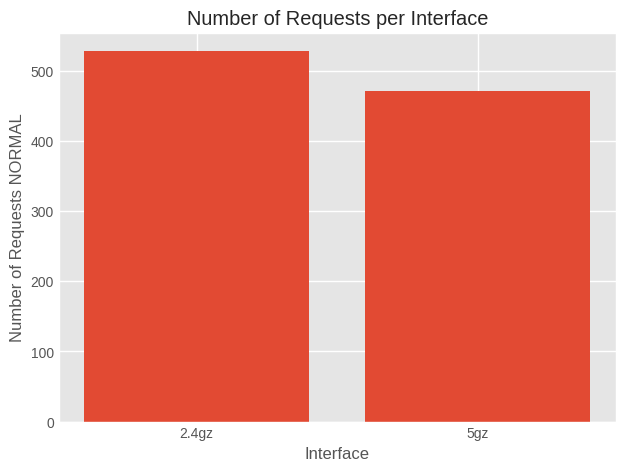

In [64]:
import matplotlib.pyplot as plt

# assuming you have a DataFrame called `normal_log_db` with a column called 'Interface'
interface_counts = normal_log_db['Interface'].value_counts()

# create a bar plot of the interface counts
plt.bar(interface_counts.index, interface_counts.values)

# set the title and axis labels
plt.title('Number of Requests per Interface')
plt.xlabel('Interface')
plt.ylabel('Number of Requests NORMAL')

# display the plot
plt.show()

In [65]:
# lets now simulate an attack by a vivo device. 